In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, classification_report

2025-10-26 16:40:57.443687: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-26 16:40:57.452627: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-26 16:40:57.463125: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-26 16:40:57.466312: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-26 16:40:57.474228: I tensorflow/core/platform/cpu_feature_guar

In [4]:
# Defining for Training Data (Rescale & Augment) using ImageDataGenerator

train_gen = ImageDataGenerator(rescale=1./255,       # Normalizes the pixel image to [0,1]
                               rotation_range=20,    # Rotates the image upto + or - 20 degree
                               zoom_range=0.2,       # Zooms the image in range [0.8(80%), 1.2(120%)]
                               horizontal_flip=True, # Flipps the image left or right
                               fill_mode='nearest')  # Fills empty pixels to nearest value after augmenting

# Defining for Validation and Test Data (Rescale) using ImageDataGenerator

val_test_gen = ImageDataGenerator(rescale=1./255)                               

img_h = 224
img_w = 224
batch_size = 32

In [6]:
# Loading Datasets

train_ds = train_gen.flow_from_directory("images/data/train",
                                         target_size=(img_h, img_w),
                                         batch_size=batch_size,
                                         class_mode='categorical')

val_ds = val_test_gen.flow_from_directory("images/data/val",
                                          target_size=(img_h, img_w),
                                          batch_size=batch_size,
                                          class_mode='categorical')

test_ds = val_test_gen.flow_from_directory("images/data/test",
                                           target_size=(img_h, img_w),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)    # For correct label matching during evaluation

Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [9]:
# Class names in Dataset

classes = list(train_ds.class_indices)
print(classes)

print(test_ds.num_classes)

['animal fish', 'animal fish bass', 'fish sea_food black_sea_sprat', 'fish sea_food gilt_head_bream', 'fish sea_food hourse_mackerel', 'fish sea_food red_mullet', 'fish sea_food red_sea_bream', 'fish sea_food sea_bass', 'fish sea_food shrimp', 'fish sea_food striped_red_mullet', 'fish sea_food trout']
11


In [10]:
val_ds.filepaths[:5]

['images/data/val/animal fish/00INXORZNTLJ.jpg',
 'images/data/val/animal fish/037HBUROQJPG.jpg',
 'images/data/val/animal fish/04H7O05DX3CU.jpg',
 'images/data/val/animal fish/09K1Q2K4PL5O.jpg',
 'images/data/val/animal fish/0BL5YTSEHIRZ.jpg']

In [11]:
images, labels = next(train_ds) # Get single batch of train dataset
print(images.shape)
print(labels.shape)

(32, 224, 224, 3)
(32, 11)


In [12]:
val_ds.num_batches

35

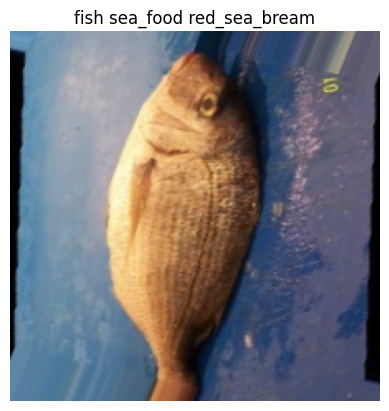

In [16]:
plt.imshow(images[4])
plt.title(classes[labels[4].argmax()])
plt.axis("off")
plt.show()

In [17]:
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(img_h, img_w, 3)),
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(train_ds.num_classes, activation='softmax')])

I0000 00:00:1761477868.822354  149102 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-10-26 16:54:28.845560: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [18]:
cnn_model.compile(optimizer='adam',
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

In [19]:
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 11)             │         1,419 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,851 (49.36 MB)

 Trainable params: 12,939,851 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                               patience=5,
                               restore_best_weights=True,
                               verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath="Trained Models/best_model_CNN.keras",
                             monitor="val_loss",
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=True)

In [21]:
cnn_history = cnn_model.fit(train_ds,
                            validation_data=val_ds,
                            epochs=15,
                            callbacks = [early_stopping, checkpoint])

/home/kishore/Multiclass-image-classification/venv310/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step - accuracy: 0.3048 - loss: 2.0714
Epoch 1: val_loss improved from None to 1.01022, saving model to Trained Models/best_model_CNN.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 97s 490ms/step - accuracy: 0.4080 - loss: 1.6937 - val_accuracy: 0.6758 - val_loss: 1.0102
Epoch 2/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.5884 - loss: 1.1371
Epoch 2: val_loss improved from 1.01022 to 0.70620, saving model to Trained Models/best_model_CNN.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 91s 467ms/step - accuracy: 0.6289 - loss: 1.0545 - val_accuracy: 0.7857 - val_loss: 0.7062
Epoch 3/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.6946 - loss: 0.8736
Epoch 3: val_loss improved from 0.70620 to 0.58940, saving model to Trained Models/best_model_CNN.keras
195/195 ━━━━━━━━━━━━━━━━━━━━ 91s 466ms/step - accuracy: 0.7096 - loss: 0.8278 - val_accuracy: 0.8507 - val_loss: 0.5894
Epoch 4/15
195/195 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0

In [22]:
train_accuracy = cnn_history.history['accuracy']
train_loss = cnn_history.history['loss']

val_accuracy = cnn_history.history['val_accuracy']
val_loss = cnn_history.history['val_loss']

epochs = range(1, len(train_accuracy)+1)

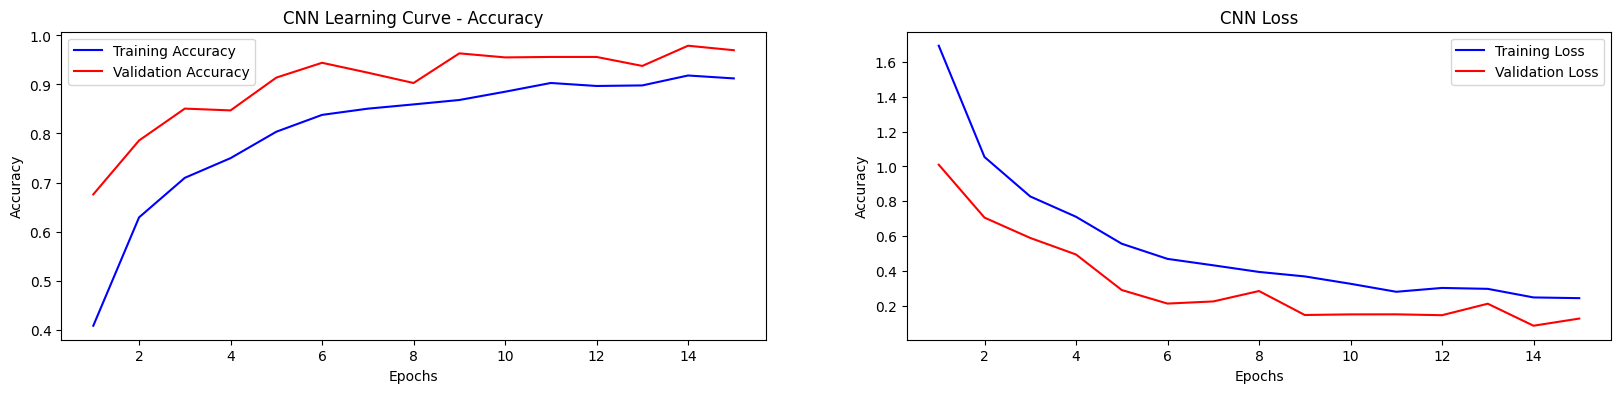

In [23]:
plt.figure(figsize=(20,4))
plt.subplot(1,2,1)
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN Learning Curve - Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("CNN Loss")

plt.show()

In [24]:
cnn_model.save('Trained Models/multiclass_fish_cnn_model.h5')

In [25]:
cnn_model.save('Trained Models/multiclass_fish_cnn_model.keras')

In [26]:
# Evaluating model based on accuracy

cnn_loss, cnn_accuracy = cnn_model.evaluate(test_ds)
cnn_accuracy

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.9755 - loss: 0.0949


0.9755255579948425

> **Finding Prediction Classes and True Classes**

In [27]:
# Getting Predictions Probabilities and Predicted Classes

y_probs = cnn_model.predict(test_ds)
y_pred = np.argmax(y_probs, axis=1)

100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 101ms/step


In [28]:
y_pred.shape

(3187,)

In [29]:
y_true = test_ds.classes
y_true.shape

(3187,)

In [33]:
## Numeric to Categorical

y_true_labels = [classes[labels] for labels in y_true]
y_pred_labels = [classes[labels] for labels in y_pred]
print(y_true_labels)
print(y_pred_labels)

['animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal fish', 'animal f

> **Performance Metrics**

In [35]:
# Other Performance Metrics Calculations

cnn_precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
cnn_recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
cnn_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
cnn_cm = confusion_matrix(y_true_labels, y_pred_labels)

print("CNN Model Performance Metrics:\n")
print(f" Accuracy : {cnn_accuracy*100:.4f}%")
print(f" Loss     : {cnn_loss:.4f}")
print(f" Precision: {cnn_precision:.4f}")
print(f" Recall   : {cnn_recall:.4f}")
print(f" F1 Score : {cnn_f1:.4f}")

CNN Model Performance Metrics:

 Accuracy : 97.5526%
 Loss     : 0.0949
 Precision: 0.9721
 Recall   : 0.9755
 F1 Score : 0.9735


In [36]:
cnn_cm

array([[515,   0,   2,   1,   0,   1,   0,   0,   0,   0,   1],
       [ 13,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 297,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 274,   0,   0,  27,   3,   0,   0,   1],
       [  0,   0,   0,   0, 286,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 291,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 267,   5,   0,   0,   1],
       [  0,   0,   5,   4,   5,   0,   2, 311,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 289,   0,   0],
       [  0,   0,   1,   0,   1,   0,   0,   2,   2, 287,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 292]])

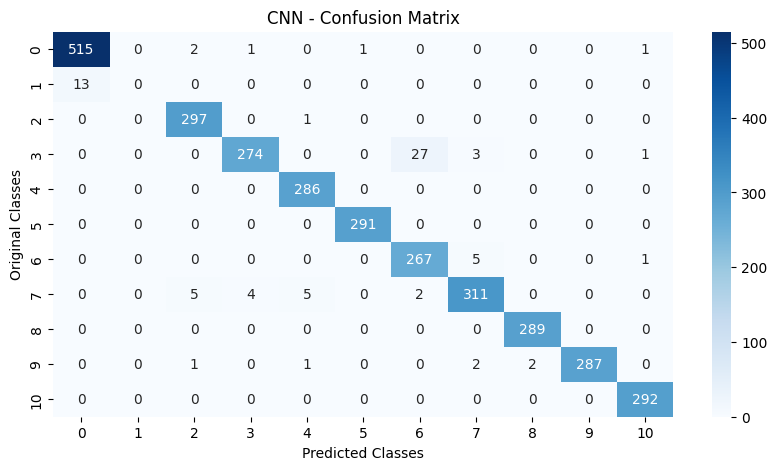

In [44]:
plt.figure(figsize=(10,5))
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Classes")
plt.ylabel("Original Classes")
plt.title("CNN - Confusion Matrix")
plt.show()

In [37]:
print(test_ds.class_indices)

{'animal fish': 0, 'animal fish bass': 1, 'fish sea_food black_sea_sprat': 2, 'fish sea_food gilt_head_bream': 3, 'fish sea_food hourse_mackerel': 4, 'fish sea_food red_mullet': 5, 'fish sea_food red_sea_bream': 6, 'fish sea_food sea_bass': 7, 'fish sea_food shrimp': 8, 'fish sea_food striped_red_mullet': 9, 'fish sea_food trout': 10}


In [43]:
test_ds.class_indices

{'animal fish': 0,
 'animal fish bass': 1,
 'fish sea_food black_sea_sprat': 2,
 'fish sea_food gilt_head_bream': 3,
 'fish sea_food hourse_mackerel': 4,
 'fish sea_food red_mullet': 5,
 'fish sea_food red_sea_bream': 6,
 'fish sea_food sea_bass': 7,
 'fish sea_food shrimp': 8,
 'fish sea_food striped_red_mullet': 9,
 'fish sea_food trout': 10}

In [45]:
# Classification Report (per-class)

cnn_cr = classification_report(y_true, y_pred, target_names=classes, zero_division=0)
print(cnn_cr)

                                  precision    recall  f1-score   support

                     animal fish       0.98      0.99      0.98       520
                animal fish bass       0.00      0.00      0.00        13
   fish sea_food black_sea_sprat       0.97      1.00      0.99       298
   fish sea_food gilt_head_bream       0.98      0.90      0.94       305
   fish sea_food hourse_mackerel       0.98      1.00      0.99       286
        fish sea_food red_mullet       1.00      1.00      1.00       291
     fish sea_food red_sea_bream       0.90      0.98      0.94       273
          fish sea_food sea_bass       0.97      0.95      0.96       327
            fish sea_food shrimp       0.99      1.00      1.00       289
fish sea_food striped_red_mullet       1.00      0.98      0.99       293
             fish sea_food trout       0.99      1.00      0.99       292

                        accuracy                           0.98      3187
                       macro avg    